# **L&T EduTech Hackathon at SHAASTRA IITM**

Here we will try to find optimum training data in percentage with the help of pretrained model that we selected earlier. The judging metric is Cohen Kappa score. 

### Kappa Score:
Cohen’s kappa measures the agreement between two raters who each classify N items into C mutually exclusive categories.

More on Cohen kappa score can be found [here](https://towardsdatascience.com/cohens-kappa-9786ceceab58).

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras import layers
import keras.backend as K
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization, Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.applications.imagenet_utils import preprocess_input


from PIL import Image
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

!pip install opendatasets
import opendatasets as od

In [2]:
#od.download('https://www.kaggle.com/datasets/arpitjain007/game-of-deep-learning-ship-datasets/code')

In [3]:
dataset_path = r'/kaggle/input/game-of-deep-learning-ship-datasets'  # main data folder path
train_path = os.path.join(dataset_path, 'train')
images_path = os.path.join(train_path, 'images')
test_csv = os.path.join(dataset_path, 'test_ApKoW4T.csv')
train_csv = os.path.join(train_path, 'train.csv')

test_df = pd.read_csv(test_csv)
train_df = pd.read_csv(train_csv) # it contains image names and their respective labels

num_test_img = len(test_df)
num_train_img = len(train_df)

print(f'Total Number of test images: {num_test_img}')
print(f'Total Number of train images: {num_train_img}')

Total Number of test images: 2680
Total Number of train images: 6252


In [4]:
main_path = "/kaggle/input/game-of-deep-learning-ship-datasets/train/images/"   # it contains all the images
main_df = pd.read_csv(r'/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv')
paths = os.listdir(main_path)
main_df['path'] = main_path + main_df['image']    # In the path column, paths of all images saved.

categories = list(main_df['category'])   # Saves list of ship categories.
categorys = {1:'Cargo', 2:'Military', 3:'Carrier', 4:'Cruise', 5:'Tankers'}

In [5]:
classes = []
for category in categories:
    classes.append(categorys[category])         # Ship category is saved in classes sequencially.


main_df['classes'] = classes
test_df = pd.read_csv(r'/kaggle/input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv')
test_df['path'] = main_path + test_df['image']

In [6]:
widths, heights = [], []

for path in tqdm(main_df["path"]):
    width, height = Image.open(path).size
    widths.append(width)
    heights.append(height)
    
main_df["width"] = widths
main_df["height"] = heights
main_df["dimension"] = main_df["width"] * main_df["height"]

100%|██████████| 6252/6252 [00:21<00:00, 291.53it/s]


In [7]:
X, y = main_df[['path', 'classes']], main_df['classes']

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  # 10% test and validation data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)  # 5% test data and 5% validation data

In [8]:
datagen = ImageDataGenerator(rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
) 

val_generator = datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
test_generator = datagen.flow_from_dataframe(
        X_test,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=False,
)

Found 313 validated image filenames belonging to 5 classes.
Found 313 validated image filenames belonging to 5 classes.


In [9]:
from tensorflow.keras.applications.xception import Xception
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
IMG_SHAPE = (224,224,3)
xception_model = Xception(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

2023-01-17 04:04:44.020596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 04:04:44.111266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 04:04:44.112090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 04:04:44.113329: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 3s 0us/step


In [10]:
test_size1 = [0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
from keras.models import load_model

kappa_score = {}
saved_models = ['model10.h5','model20.h5','model30.h5','model40.h5','model50.h5','model60.h5','model70.h5','model80.h5']
X_train = {}
X_v = {}
y_train= {}
y_v = {}
for i in range(len(test_size1)):
    X_train[i], X_v[i], y_train[i], y_v[i] = train_test_split(X_data, y_data, test_size= test_size1[i]/0.9, random_state=42)
  
    train_generator = datagen.flow_from_dataframe(
        X_train[i],  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        )

    model_xception = tf.keras.Sequential([
    xception_model,
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
  ])

    model_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

    history_xception = model_xception.fit(
      train_generator,
      validation_data=val_generator,
      epochs=20,
      verbose=2)

    model_xception.save(saved_models[i])

    y_pred = model_xception.predict(test_generator)

    y_pred_classes = np.argmax(y_pred, axis = 1)
    print("\nAccuracy:",metrics.accuracy_score(test_generator.labels, y_pred_classes))
    print('\nF1 Score is',f1_score(test_generator.labels, y_pred_classes, average='weighted'))
    kappa_score[i] = cohen_kappa_score(test_generator.labels, y_pred_classes)
    print('\nCohen Kappa Score is\n ',kappa_score[i])

Found 625 validated image filenames belonging to 5 classes.


2023-01-17 04:04:51.578741: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-01-17 04:04:57.070079: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


20/20 - 28s - loss: 1.1096 - accuracy: 0.5616 - val_loss: 1.8114 - val_accuracy: 0.4185
Epoch 2/20
20/20 - 15s - loss: 0.5060 - accuracy: 0.8032 - val_loss: 2.0576 - val_accuracy: 0.5335
Epoch 3/20
20/20 - 16s - loss: 0.2653 - accuracy: 0.9088 - val_loss: 1.2347 - val_accuracy: 0.6550
Epoch 4/20
20/20 - 16s - loss: 0.1378 - accuracy: 0.9568 - val_loss: 1.1563 - val_accuracy: 0.7508
Epoch 5/20
20/20 - 15s - loss: 0.1163 - accuracy: 0.9584 - val_loss: 1.3097 - val_accuracy: 0.7636
Epoch 6/20
20/20 - 16s - loss: 0.1580 - accuracy: 0.9360 - val_loss: 0.8252 - val_accuracy: 0.8147
Epoch 7/20
20/20 - 15s - loss: 0.0992 - accuracy: 0.9648 - val_loss: 0.8002 - val_accuracy: 0.8466
Epoch 8/20
20/20 - 16s - loss: 0.0519 - accuracy: 0.9840 - val_loss: 0.6927 - val_accuracy: 0.8658
Epoch 9/20
20/20 - 15s - loss: 0.0350 - accuracy: 0.9904 - val_loss: 0.8621 - val_accuracy: 0.8307
Epoch 10/20
20/20 - 16s - loss: 0.0419 - accuracy: 0.9824 - val_loss: 0.8215 - val_accuracy: 0.8371
Epoch 11/20
20/20 - 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.8849840255591054

F1 Score is 0.8839664203084161

Cohen Kappa Score is
  0.8522462038761113
Found 1250 validated image filenames belonging to 5 classes.
Epoch 1/20
40/40 - 31s - loss: 0.3539 - accuracy: 0.8824 - val_loss: 0.3738 - val_accuracy: 0.8754
Epoch 2/20
40/40 - 26s - loss: 0.2039 - accuracy: 0.9272 - val_loss: 0.5444 - val_accuracy: 0.8371
Epoch 3/20
40/40 - 27s - loss: 0.1164 - accuracy: 0.9672 - val_loss: 0.4967 - val_accuracy: 0.8850
Epoch 4/20
40/40 - 26s - loss: 0.0533 - accuracy: 0.9832 - val_loss: 0.6153 - val_accuracy: 0.8818
Epoch 5/20
40/40 - 26s - loss: 0.1148 - accuracy: 0.9696 - val_loss: 0.3935 - val_accuracy: 0.8658
Epoch 6/20
40/40 - 26s - loss: 0.0593 - accuracy: 0.9832 - val_loss: 0.4680 - val_accuracy: 0.8594
Epoch 7/20
40/40 - 26s - loss: 0.1066 - accuracy: 0.9608 - val_loss: 0.7358 - val_accuracy: 0.8466
Epoch 8/20
40/40 - 26s - loss: 0.0448 - accuracy: 0.9864 - val_loss: 0.6614 - val_accuracy: 0.8786
Epoch 9/20
40/40 - 26s - loss: 0.0401 - ac

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.8977635782747604

F1 Score is 0.8976972959646603

Cohen Kappa Score is
  0.8690650491528968
Found 1875 validated image filenames belonging to 5 classes.
Epoch 1/20
59/59 - 43s - loss: 0.1997 - accuracy: 0.9392 - val_loss: 0.3846 - val_accuracy: 0.9010
Epoch 2/20
59/59 - 36s - loss: 0.0842 - accuracy: 0.9755 - val_loss: 0.4504 - val_accuracy: 0.8914
Epoch 3/20
59/59 - 37s - loss: 0.0675 - accuracy: 0.9765 - val_loss: 0.4516 - val_accuracy: 0.8882
Epoch 4/20
59/59 - 37s - loss: 0.0491 - accuracy: 0.9835 - val_loss: 0.3782 - val_accuracy: 0.8946
Epoch 5/20
59/59 - 37s - loss: 0.0664 - accuracy: 0.9819 - val_loss: 0.5166 - val_accuracy: 0.8786
Epoch 6/20
59/59 - 36s - loss: 0.0377 - accuracy: 0.9904 - val_loss: 0.7024 - val_accuracy: 0.8307
Epoch 7/20
59/59 - 37s - loss: 0.0180 - accuracy: 0.9920 - val_loss: 0.4111 - val_accuracy: 0.9010
Epoch 8/20
59/59 - 37s - loss: 0.0372 - accuracy: 0.9909 - val_loss: 0.4280 - val_accuracy: 0.8946
Epoch 9/20
59/59 - 38s - loss: 0.0280 - ac

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.952076677316294

F1 Score is 0.9519203704976885

Cohen Kappa Score is
  0.9382529328212952
Found 2500 validated image filenames belonging to 5 classes.
Epoch 1/20
79/79 - 53s - loss: 0.1410 - accuracy: 0.9632 - val_loss: 0.2846 - val_accuracy: 0.9201
Epoch 2/20
79/79 - 47s - loss: 0.0571 - accuracy: 0.9856 - val_loss: 0.4492 - val_accuracy: 0.8850
Epoch 3/20
79/79 - 47s - loss: 0.0432 - accuracy: 0.9888 - val_loss: 0.3502 - val_accuracy: 0.9042
Epoch 4/20
79/79 - 47s - loss: 0.0512 - accuracy: 0.9876 - val_loss: 0.5407 - val_accuracy: 0.8818
Epoch 5/20
79/79 - 48s - loss: 0.0217 - accuracy: 0.9936 - val_loss: 0.5405 - val_accuracy: 0.8978
Epoch 6/20
79/79 - 47s - loss: 0.0353 - accuracy: 0.9904 - val_loss: 0.4872 - val_accuracy: 0.8882
Epoch 7/20
79/79 - 47s - loss: 0.0368 - accuracy: 0.9896 - val_loss: 0.4231 - val_accuracy: 0.8978
Epoch 8/20
79/79 - 48s - loss: 0.0144 - accuracy: 0.9944 - val_loss: 0.4882 - val_accuracy: 0.8914
Epoch 9/20
79/79 - 47s - loss: 0.0273 - acc

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.9424920127795527

F1 Score is 0.9420656040039451

Cohen Kappa Score is
  0.9258918236346417
Found 3125 validated image filenames belonging to 5 classes.
Epoch 1/20
98/98 - 63s - loss: 0.1081 - accuracy: 0.9734 - val_loss: 0.3680 - val_accuracy: 0.9073
Epoch 2/20
98/98 - 58s - loss: 0.0455 - accuracy: 0.9875 - val_loss: 0.5443 - val_accuracy: 0.9010
Epoch 3/20
98/98 - 58s - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.4788 - val_accuracy: 0.9233
Epoch 4/20
98/98 - 58s - loss: 0.0273 - accuracy: 0.9942 - val_loss: 0.4281 - val_accuracy: 0.9105
Epoch 5/20
98/98 - 58s - loss: 0.0217 - accuracy: 0.9926 - val_loss: 0.4318 - val_accuracy: 0.9233
Epoch 6/20
98/98 - 58s - loss: 0.0325 - accuracy: 0.9898 - val_loss: 0.3698 - val_accuracy: 0.8914
Epoch 7/20
98/98 - 58s - loss: 0.0249 - accuracy: 0.9949 - val_loss: 0.4598 - val_accuracy: 0.9010
Epoch 8/20
98/98 - 58s - loss: 0.0263 - accuracy: 0.9933 - val_loss: 0.5978 - val_accuracy: 0.9010
Epoch 9/20
98/98 - 58s - loss: 0.0236 - ac

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.9329073482428115

F1 Score is 0.9325680494613631

Cohen Kappa Score is
  0.9136199963203406
Found 3750 validated image filenames belonging to 5 classes.
Epoch 1/20
118/118 - 74s - loss: 0.0827 - accuracy: 0.9773 - val_loss: 0.2656 - val_accuracy: 0.9169
Epoch 2/20
118/118 - 68s - loss: 0.0355 - accuracy: 0.9901 - val_loss: 0.3190 - val_accuracy: 0.9137
Epoch 3/20
118/118 - 68s - loss: 0.0294 - accuracy: 0.9928 - val_loss: 0.2821 - val_accuracy: 0.9105
Epoch 4/20
118/118 - 69s - loss: 0.0225 - accuracy: 0.9939 - val_loss: 0.4068 - val_accuracy: 0.9265
Epoch 5/20
118/118 - 68s - loss: 0.0229 - accuracy: 0.9933 - val_loss: 0.3469 - val_accuracy: 0.9297
Epoch 6/20
118/118 - 68s - loss: 0.0245 - accuracy: 0.9941 - val_loss: 0.3530 - val_accuracy: 0.9201
Epoch 7/20
118/118 - 68s - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.2882 - val_accuracy: 0.9265
Epoch 8/20
118/118 - 70s - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.2668 - val_accuracy: 0.9361
Epoch 9/20
118/118 - 68s -

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.9552715654952076

F1 Score is 0.9548044899550644

Cohen Kappa Score is
  0.942345139729488
Found 4375 validated image filenames belonging to 5 classes.
Epoch 1/20
137/137 - 84s - loss: 0.0747 - accuracy: 0.9845 - val_loss: 0.4184 - val_accuracy: 0.9010
Epoch 2/20
137/137 - 80s - loss: 0.0226 - accuracy: 0.9938 - val_loss: 0.2337 - val_accuracy: 0.9297
Epoch 3/20
137/137 - 78s - loss: 0.0175 - accuracy: 0.9959 - val_loss: 0.3742 - val_accuracy: 0.9201
Epoch 4/20
137/137 - 78s - loss: 0.0207 - accuracy: 0.9943 - val_loss: 0.3543 - val_accuracy: 0.9233
Epoch 5/20
137/137 - 78s - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.3111 - val_accuracy: 0.9329
Epoch 6/20
137/137 - 79s - loss: 0.0142 - accuracy: 0.9952 - val_loss: 0.3604 - val_accuracy: 0.9169
Epoch 7/20
137/137 - 78s - loss: 0.0139 - accuracy: 0.9968 - val_loss: 0.4621 - val_accuracy: 0.9073
Epoch 8/20
137/137 - 79s - loss: 0.0168 - accuracy: 0.9952 - val_loss: 0.6740 - val_accuracy: 0.8850
Epoch 9/20
137/137 - 79s - 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.9584664536741214

F1 Score is 0.9582392717675204

Cohen Kappa Score is
  0.9465041676527044
Found 5000 validated image filenames belonging to 5 classes.
Epoch 1/20
157/157 - 95s - loss: 0.0708 - accuracy: 0.9854 - val_loss: 0.3122 - val_accuracy: 0.9201
Epoch 2/20
157/157 - 89s - loss: 0.0325 - accuracy: 0.9922 - val_loss: 0.3005 - val_accuracy: 0.9425
Epoch 3/20
157/157 - 89s - loss: 0.0251 - accuracy: 0.9938 - val_loss: 0.3475 - val_accuracy: 0.9233
Epoch 4/20
157/157 - 89s - loss: 0.0111 - accuracy: 0.9962 - val_loss: 0.3987 - val_accuracy: 0.9329
Epoch 5/20
157/157 - 89s - loss: 0.0175 - accuracy: 0.9938 - val_loss: 0.3592 - val_accuracy: 0.9489
Epoch 6/20
157/157 - 89s - loss: 0.0150 - accuracy: 0.9952 - val_loss: 0.3309 - val_accuracy: 0.9329
Epoch 7/20
157/157 - 89s - loss: 0.0205 - accuracy: 0.9944 - val_loss: 0.4979 - val_accuracy: 0.9169
Epoch 8/20
157/157 - 89s - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.4756 - val_accuracy: 0.9265
Epoch 9/20
157/157 - 89s -

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.9584664536741214

F1 Score is 0.958126913593034

Cohen Kappa Score is
  0.9467282867691341


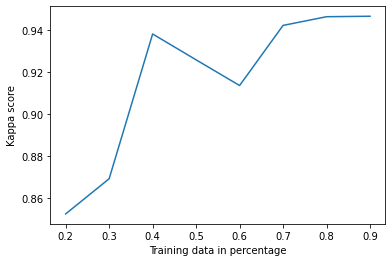

In [11]:
train_data_per = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
kappa_score = np.array(list(kappa_score.items())).T[1]
plt.plot(train_data_per,kappa_score)
plt.xlabel('Training data in percentage')
plt.ylabel('Kappa score')
plt.show()